In [ ]:
# ### Install necessary packages
# !pip install agentpy mesa matplotlib

# Import required libraries
import agentpy as ap
import time
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import random

# ### 1. AgentPy Money Simulation ###

class WealthAgent(ap.Agent):

    """ An agent with wealth """

    def setup(self):

        self.wealth = 1

    def wealth_transfer(self):

        if self.wealth > 0:

            partner = self.model.agents.random()
            partner.wealth += 1
            self.wealth -= 1

class WealthModelAP(ap.Model):

    """ A simple model of random wealth transfers """
    def __init__(self,n):
        num_agents = n

    def gini(self,x):

        """ Calculate Gini Coefficient """
        # By Warren Weckesser https://stackoverflow.com/a/39513799

        x = np.array(x)
        mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
        rmad = mad / np.mean(x)  # Relative mean absolute difference
        return 0.5 * rmad

    def setup(self):

        self.agents = ap.AgentList(self, self.p.agents, WealthAgent)

    def step(self):

        self.agents.wealth_transfer()

    def update(self):

        self.record('Gini Coefficient', self.gini(self.agents.wealth))

    def end(self):

        self.agents.record('wealth')
# ### 2. Mesa Money Simulation ###

class MoneyAgentMesa(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = random.choice(self.model.agent_list)
        if other_agent is not self:  # Zorg ervoor dat agent niet zichzelf kiest
            other_agent.wealth += 1
            self.wealth -= 1

class MoneyModelMesa(Model):
    def __init__(self, N):
        self.running = True
        self.num_agents = N
        self.agent_list = []  # Lijst voor agenten
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.agent_list.append(a)  # Voeg agent toe aan lijst

        self.collector = DataCollector(
            agent_reporters={"Wealth": "wealth"}  # Verzamel rijkdom voor elke agent
        )

    def step(self):
        self.collector.collect(self)
        for agent in self.agent_list:
            agent.step()  # Roep de 'step' methode van elke agent aan

# ### 3. Performance Comparison ###

# We willen de prestaties vergelijken door de simulatie voor beide modellen uit te voeren met hetzelfde aantal agenten.

def test_comparison():
    agent_counts = [10, 100, 1000, 5000, 10000]
    results = {'AgentPy': [], 'Mesa': []}

    for num_agents in agent_counts:
        # **AgentPy simulation**
        start = time.time()
        model_ap = WealthModelAP(n=num_agents)
        for _ in range(10):
            model_ap.step()
        agentpy_time = time.time() - start
        
        # **Mesa simulation**
        start = time.time()
        model_mesa = MoneyModelMesa(num_agents)
        for _ in range(10):
            model_mesa.step()
        mesa_time = time.time() - start
        
        results['AgentPy'].append(agentpy_time)
        results['Mesa'].append(mesa_time)
    
    return results

# Run the comparison test
comparison_results = test_comparison()

# ### 4. Plotting the Results ###

# Plotting the execution time for both AgentPy and Mesa models
plt.figure()
for lib in comparison_results:
    plt.plot([10, 100, 1000, 5000, 10000], comparison_results[lib], label=lib)
plt.xlabel("Number of Agents")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.title("Execution Time Comparison: AgentPy vs. Mesa")
plt.show()



### Vergelijking ABM libary's

## Omschrijving
Notebook gemaakt om de verschillen te bekijken tussen de verschillende libarys die we zouden kunnen gebruiken in ons project

De volgende libarys hebben wij in overweging genomen.
- Mesa
- AgentPy
- BPTK-Py
- GAMA

Van af het begin is het all snel duidelijk dat GAMA afvalt aangezien dit een volledig eigen installatie heeft en niet een python libary.

We kijken vooral naar gemak van het opstellen van een simulatie en de snelheid mee waar de simulatie runt.

#### Benodigde imports
Deze imports zijn nodig om de notebook te kunnen draaien en de resultaten te plotten.

In [ ]:
# Import of libary's
# AgentPy
import agentpy as ap
# Mesa
import mesa
# Data visualization tools.
import seaborn as sns
# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np
# Data manipulation and analysis.
import pandas as pd

#### Pandas dataframe
Om de verkregen data per simulatie run op te slaan. Om later te plotten in grafieken.

In [ ]:
# Sim info dataframe.
sim_info_df = pd.DataFrame()


#### AgentPy Setup
Hier onder is de classen structuur en functies te vinden voor de AgentPy simulatie.

In [ ]:
class MoneyAgent(ap.Agent):

    def setup(self):
        self.wealth = 1

    def wealth_transfer(self):
        if self.wealth == 0:
            return
        a = self.model.agents.random()
        a.wealth += 1
        self.wealth -= 1

class MoneyModel(ap.Model):

    def setup(self):
        self.agents = ap.AgentList(
            self, self.p.n, MoneyAgent)

    def step(self):
        self.agents.record('wealth')
        self.agents.wealth_transfer()
        
# Perform single run
parameters = {'n': 10, 'steps': 10}
model = MoneyModel(parameters)
results = model.run()

# Perform multiple runs
variable_params = {
    'n': ap.IntRange(10, 500), 
    'steps': 10
}
sample = ap.Sample(variable_params, n=49)
exp = ap.Experiment(
    MoneyModel,
    sample,
    iterations=5,
    record=True
)
results = exp.run()

Completed: 10 steps
Run time: 0:00:00.002397
Simulation finished
Scheduled runs: 245
Completed: 245, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:02.488831


#### MESA Setup
Hier onder is de setup voor dezelfde simulatie te vinden alleen in dit geval is er mesa gebruikt.


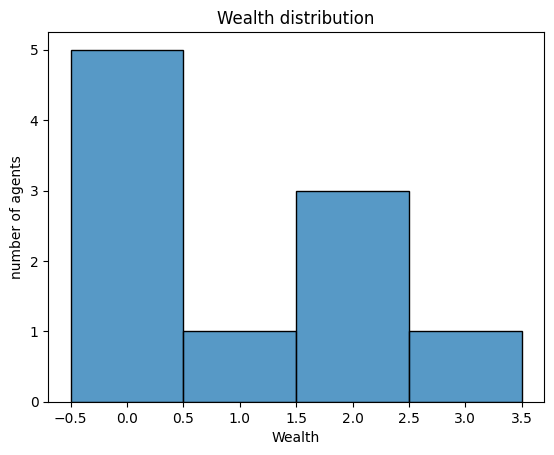

In [ ]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's variable and set the initial values.
        self.wealth = 1

    def exchange(self):
        # Verify agent has some wealth
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.agents)
            if other_agent is not None:
                other_agent.wealth += 1
                self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create agents
        MoneyAgent.create_agents(model=self, n=n)

    def step(self):
        """Advance the model by one step."""

        # This function psuedo-randomly reorders the list of agent objects and
        # then iterates through calling the function passed in as the parameter
        self.agents.shuffle_do("exchange")


model = MoneyModel(10)  # Tells the model to create 10 agents
for _ in range(
    30
):  # Runs the model for 10 steps; an underscore is common convention for a variable that is not used
    model.step()

agent_wealth = [a.wealth for a in model.agents]
# Create a histogram with seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(
    title="Wealth distribution", xlabel="Wealth", ylabel="number of agents"
);  # The semicolon is just to avoid printing the object representation